# Project

In [1]:
import sys

In [2]:
import re
_r = re.escape
def _re_replace(s : str, to_replace : dict):
    for p, r in to_replace.items():
        s = re.compile(p).sub(r, s)
    return s

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [4]:
!{sys.executable} -m pip install --quiet pandas
import pandas as pd

In [5]:
!{sys.executable} -m pip install --quiet seaborn
import seaborn as sns

In [6]:
# OLS using statsmodels
!{sys.executable} -m pip install --quiet statsmodels numpy seaborn
import statsmodels.api as sm
import numpy as np

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Data

The dataset<sup><a name="note-cariboo" href="#cariboo">[7]</a></sup> is composed of 7 different subsets, we will be using 4 of the datasets. Since each feature resides in different sets. 

- `Appearances.csv`
    - Player ID, Game ID, Appearance ID, Competition ID, Player club ID, Assist, Minutes Played, Yellow cards, Red Cards
- `Clubs.csv `
    - Club ID, Name, Pretty_name, Domestic_competition_id, Total_market_value, Squad_size, Average_age, Foreigners_numbers, Foreigners_percentage, National_team_players, Stadium_name, Stadium_seats, Net_transfer_record, Coach_name, URL
- `Competitions.csv`
    - Competition_id, Name, type, country_id, country_name, domestic_league_code, confederation, URL.  
- `Games.csv` 
    - Game_id, Competition_code, Season, Round, Date, Home_club_id, Away_club_id, Home_club_goals, away_club_goals, Home_club_postions, Away_club_postion, Stadium, Attendance, Referee, URL 
- `Leagues.csv` 
    - League_id, name, Confederation
- `Player_valuations.csv` 
    - Player_id, Date, Market_value
- `Players.csv`
    - Player_id, Last_season, Current_club_id, Name, Pretty_name, country_of_birth, Country_of_citizenship, Date_of_birth, Position, Sub_position, Foot, Height_in_cm, Market_value_in_gbp, Highest_market_value_in_gbp, URL

- _What an observation consists of_: We are trying to use the variables we assume to be the most important and independent from each other. We decided on 
    - Club, Nationality, League, Appearances, Minutes, Goals, Assist, Age, Conduct, Media Presence, Years Played, Trophies, Experience, Position, Physicality, Potential. 
- _What some critical variables are, how they are represented_: We want variables which have the highest co-variance with each other. The metric should handle most features as unique features. 
- _Any special handling, transformations, cleaning, etc will be needed_: There will be club names, and probably inferences in our data. Such as Media Presence or Potential, these are metrics which can be objective to the person. How popular is the player that we are analyzing? 

We are still going to be in search of more databases that might have different descriptive data that we might like to see how organizations search for talent. We can use what they might describe as their most sought out characteristics. 

For Simplicity we can also assume that all players have no contracts for their evaluation and are based solely on performance and the other variables mentioned.

In [7]:
_data_ = {
    name: pd.read_csv(
        file, 
        engine = 'c',
        low_memory = True,
        memory_map = False, # set `False` to load into memory
        **kwargs
    ) for name, file, kwargs in [
        ('appearances', 'data/appearances.csv', {}),
        ('clubs', 'data/clubs.csv', {}),
        ('competitions', 'data/competitions.csv', {}),
        ('games', 'data/games.csv', {}),
        ('leagues', 'data/leagues.csv', {}),
        ('players', 'data/players.csv', {
            'parse_dates': ['date_of_birth'],
            'dtype': {
                'country_of_birth': 'category',
                'country_of_citizenship': 'category',
                'position': 'category',
                'sub_position': 'category'
            }
        }),
        ('player_valuations', 'data/player_valuations.csv', {
            'parse_dates': ['date']
        })
    ]
}

In [8]:
data = {}

In [9]:
# clubs
data['clubs'] = _data_['clubs'].copy()

data['clubs'] = data['clubs'][[
    'club_id', 
    'pretty_name'
]]
data['clubs'].rename(
    columns = {'pretty_name': 'club_name'},
    inplace = True
)
data['clubs'].set_index('club_id', inplace = True)

data['clubs']

,club_name
club_id,
1032,Fc Reading
2323,Orduspor
1387,Acn Siena 1904
3592,Kryvbas Kryvyi Rig
1071,Wigan Athletic
...,...
1269,Pec Zwolle
200,Fc Utrecht
317,Fc Twente Enschede


In [10]:
# games
data['games'] = _data_['games'].copy()

data['games'] = data['games'][[
    'season', 
    'game_id'
]]
data['games'].set_index('game_id', inplace = True)

data['games']

,season
game_id,
2244388,2012
2219794,2011
2244389,2012
2271112,2012
2229332,2012
...,...
3646190,2021
3646188,2021
3655616,2021


In [11]:
# appearances
data['appearances'] = _data_['appearances'].copy()

data['appearances'] = data['appearances'].loc[
    :, ~data['appearances'].columns.isin([
        'appearance_id', 
        'competition_id'
    ])
]
data['appearances'].rename(
    columns = {'player_club_id': 'club_id'},
    inplace = True
)

data['appearances'] = (
    data['appearances']
        .merge(
            data['games'], 
            on = 'game_id',
            copy = False
        ).drop(columns = 'game_id')
        .merge(
            data['clubs'], 
            on = 'club_id',
            copy = False
        ).drop(columns = 'club_id')
)

data['appearances'] = (
    data['appearances']
        .groupby(['player_id', 'season'])
        .agg({
            **{
                c: 'sum' for c in [
                    'goals', 
                    'assists', 
                    'minutes_played', 
                    'yellow_cards', 
                    'red_cards'
                ]
            },
            'club_name': 'last'
        })
        .reset_index('season')
)

data['appearances']

,season,goals,assists,minutes_played,yellow_cards,red_cards,club_name
player_id,,,,,,,
10,2014,16,9,2289,6,0,Lazio Rom
10,2015,8,7,1714,3,0,Lazio Rom
26,2014,0,0,2880,0,0,Borussia Dortmund
26,2015,0,0,1260,1,0,Borussia Dortmund
26,2016,0,0,1020,0,0,Borussia Dortmund
...,...,...,...,...,...,...,...
926954,2021,0,0,24,1,0,Fc Nordsjaelland
926987,2021,0,0,3,0,0,Aalborg Bk
934034,2021,0,0,3,0,0,Volos Nps


In [12]:
# player valuations
data['player_valuations'] = _data_['player_valuations'].copy()

data['player_valuations']['season'] = (
    pd.DatetimeIndex(data['player_valuations']['date']).year
)
data['player_valuations'].drop(columns = 'date', inplace = True)

data['player_valuations'] = (
    data['player_valuations']
        .groupby(['player_id', 'season'])
        .agg({'market_value': 'mean'})
        .reset_index('season')
)
data['player_valuations'].rename(
    columns = {'market_value_in_gbp': 'market_value'},
    inplace = True
)

data['player_valuations']

,season,market_value
player_id,,
10,2004,6300000.0
10,2005,10800000.0
10,2006,22500000.0
10,2007,20700000.0
10,2008,18000000.0
...,...,...
928831,2021,45000.0
928831,2022,45000.0
934034,2021,45000.0


In [13]:
# players
data['players'] = _data_['players'].copy()

data['players'] = data['players'].loc[
    :, ~data['players'].columns.isin([
        'last_season',
        'name',
        'current_club_id',
        'market_value_in_gbp',
        'highest_market_value_in_gbp',
        'country_of_birth',
        'url', 
        'foot'
    ])
]
data['players'].rename(
    columns = {
        'pretty_name': 'name',
        'height_in_cm': 'height',
        'country_of_citizenship': 'nationality'
    },
    inplace = True
)

data['players']['sub_position'] = (
    data['players']['sub_position'].cat
        .rename_categories(
            lambda s: (
                _re_replace(s, {
                    fr'''^(.*){_r(' - ')}(.*)$''': r'\2'
                })
                .title()
            )
        )
)

data['players'].set_index('player_id', inplace = True)

data['players']

,name,nationality,date_of_birth,position,sub_position,height
player_id,,,,,,
254016,Arthur Delalande,France,1992-05-18,Midfield,Central Midfield,186
51053,Daniel Davari,Iran,1988-01-06,Goalkeeper,Goalkeeper,192
31451,Torsten Oehrl,Germany,1986-01-07,Attack,Centre-Forward,192
44622,Vladimir Kisenkov,Russia,1981-10-08,Defender,Right-Back,182
30802,Oscar Diaz,Spain,1984-04-24,Attack,Centre-Forward,183
...,...,...,...,...,...,...
462285,Fabian De Keijzer,Netherlands,2000-05-10,Goalkeeper,Goalkeeper,193
368612,Merveille Bokadi,DR Congo,1996-05-21,Defender,Centre-Back,186
408574,Joey Veerman,Netherlands,1998-11-19,Midfield,Central Midfield,185


In [14]:
# final dataset
data['all'] = data['players'].merge(
    data['player_valuations'].merge(
        data['appearances'], 
        on = ['player_id', 'season'],
        copy = False
    ), 
    on = 'player_id',
    copy = False
)

data['all']['age'] = (
    pd.to_datetime(data['all']['season'], format = '%Y', utc = True) 
        - pd.to_datetime(data['all']['date_of_birth'], utc = True)
).astype('timedelta64[Y]')
data['all'].drop(columns = 'date_of_birth', inplace = True)

data['all']

,name,nationality,position,sub_position,height,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,club_name,age
player_id,,,,,,,,,,,,,,
9800,Artem Milevskyi,Ukraine,Attack,Centre-Forward,189,2020,90000.0,0,0,360,3,0,Fk Minaj,34.0
43084,Gaetano Berardi,Switzerland,Defender,Right-Back,179,2020,360000.0,0,0,114,0,0,Leeds United,31.0
230826,Gennaro Acampora,Italy,Midfield,Central Midfield,174,2020,360000.0,1,2,624,2,0,Spezia Calcio,25.0
198087,Matteo Ricci,Italy,Midfield,Defensive Midfield,176,2020,1530000.0,0,3,2440,5,0,Spezia Calcio,25.0
110689,Deniz Mehmet,Turkey,Goalkeeper,Goalkeeper,192,2020,68000.0,0,0,540,0,0,Dundee United Fc,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364245,Jordan Teze,Netherlands,Defender,Centre-Back,183,2019,420000.0,0,0,180,0,0,Psv Eindhoven,19.0
364245,Jordan Teze,Netherlands,Defender,Centre-Back,183,2020,1102500.0,0,1,3747,5,0,Psv Eindhoven,20.0
364245,Jordan Teze,Netherlands,Defender,Centre-Back,183,2021,5400000.0,1,4,2630,6,0,Psv Eindhoven,21.0


## Data Evaluation

In [15]:
data['all'].dtypes

name                object
nationality       category
position          category
sub_position      category
height               int64
season               int64
market_value       float64
goals                int64
assists              int64
minutes_played       int64
yellow_cards         int64
red_cards            int64
club_name           object
age                float64
dtype: object

In [16]:
data['all'].describe()

,height,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,age
count,50790.000000,50790.000000,5.079000e+04,50790.000000,50790.000000,50790.000000,50790.000000,50790.000000,50781.000000
mean,180.795019,2017.379799,3.630494e+06,1.940185,1.474818,1402.741248,3.000413,0.071609,24.655284
std,17.701973,2.318790,8.273965e+06,3.675919,2.396752,1051.678772,3.047540,0.271891,4.375994
min,0.000000,2013.000000,9.000000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,14.000000
25%,178.000000,2015.000000,3.600000e+05,0.000000,0.000000,442.000000,1.000000,0.000000,21.000000
50%,182.000000,2017.000000,9.000000e+05,0.000000,1.000000,1283.000000,2.000000,0.000000,24.000000
75%,187.000000,2019.000000,3.150000e+06,2.000000,2.000000,2204.000000,5.000000,0.000000,28.000000
max,206.000000,2021.000000,1.800000e+08,61.000000,31.000000,5061.000000,23.000000,3.000000,42.000000


In [17]:
pd.DataFrame(data['all']['sub_position'].unique())

,0
0,Centre-Forward
1,Right-Back
2,Central Midfield
3,Defensive Midfield
4,Goalkeeper
5,Centre-Back
6,Attacking Midfield
7,Right Winger
8,Left Winger
9,Left-Back


In [18]:
data['all'][data['all']['name'] == 'Cristiano Ronaldo']

,name,nationality,position,sub_position,height,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,club_name,age
player_id,,,,,,,,,,,,,,
8198,Cristiano Ronaldo,Portugal,Attack,Centre-Forward,187,2014,96000000.0,61,23,4641,6,1,Real Madrid,28.0
8198,Cristiano Ronaldo,Portugal,Attack,Centre-Forward,187,2015,105000000.0,51,15,4293,3,0,Real Madrid,29.0
8198,Cristiano Ronaldo,Portugal,Attack,Centre-Forward,187,2016,99000000.0,42,12,4126,5,0,Real Madrid,30.0
8198,Cristiano Ronaldo,Portugal,Attack,Centre-Forward,187,2017,90000000.0,44,8,3678,5,0,Real Madrid,31.0
8198,Cristiano Ronaldo,Portugal,Attack,Centre-Forward,187,2018,96000000.0,28,10,3646,4,1,Juventus Turin,32.0
8198,Cristiano Ronaldo,Portugal,Attack,Centre-Forward,187,2019,74250000.0,35,7,3991,3,0,Juventus Turin,33.0
8198,Cristiano Ronaldo,Portugal,Attack,Centre-Forward,187,2020,54000000.0,38,4,3841,5,0,Juventus Turin,34.0
8198,Cristiano Ronaldo,Portugal,Attack,Centre-Forward,187,2021,39000000.0,24,3,3101,10,0,Juventus Turin,35.0


## One hot encode

In [19]:
# one hot encode categorical features
data['all'] = pd.get_dummies(data['all'], columns = [
    'position', 
    'sub_position', 
    'nationality', 
    'club_name'
])
data['all']

,name,height,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,age,...,club_name_West Bromwich Albion,club_name_West Ham United,club_name_Wigan Athletic,club_name_Willem Ii Tilburg,club_name_Wolverhampton Wanderers,club_name_Yeni Malatyaspor,club_name_Zenit St Petersburg,club_name_Zirka Kropyvnytskyi,club_name_Zorya Lugansk,club_name_Zska Moskau
player_id,,,,,,,,,,,,,,,,,,,,,
9800,Artem Milevskyi,189,2020,90000.0,0,0,360,3,0,34.0,...,0,0,0,0,0,0,0,0,0,0
43084,Gaetano Berardi,179,2020,360000.0,0,0,114,0,0,31.0,...,0,0,0,0,0,0,0,0,0,0
230826,Gennaro Acampora,174,2020,360000.0,1,2,624,2,0,25.0,...,0,0,0,0,0,0,0,0,0,0
198087,Matteo Ricci,176,2020,1530000.0,0,3,2440,5,0,25.0,...,0,0,0,0,0,0,0,0,0,0
110689,Deniz Mehmet,192,2020,68000.0,0,0,540,0,0,27.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364245,Jordan Teze,183,2019,420000.0,0,0,180,0,0,19.0,...,0,0,0,0,0,0,0,0,0,0
364245,Jordan Teze,183,2020,1102500.0,0,1,3747,5,0,20.0,...,0,0,0,0,0,0,0,0,0,0
364245,Jordan Teze,183,2021,5400000.0,1,4,2630,6,0,21.0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
data['all'].dtypes

name                              object
height                             int64
season                             int64
market_value                     float64
goals                              int64
                                  ...   
club_name_Yeni Malatyaspor         uint8
club_name_Zenit St Petersburg      uint8
club_name_Zirka Kropyvnytskyi      uint8
club_name_Zorya Lugansk            uint8
club_name_Zska Moskau              uint8
Length: 588, dtype: object

In [21]:
data['all'].describe()

,height,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,age,position_Attack,...,club_name_West Bromwich Albion,club_name_West Ham United,club_name_Wigan Athletic,club_name_Willem Ii Tilburg,club_name_Wolverhampton Wanderers,club_name_Yeni Malatyaspor,club_name_Zenit St Petersburg,club_name_Zirka Kropyvnytskyi,club_name_Zorya Lugansk,club_name_Zska Moskau
count,50790.000000,50790.000000,5.079000e+04,50790.000000,50790.000000,50790.000000,50790.000000,50790.000000,50781.000000,50790.000000,...,50790.000000,50790.000000,50790.000000,50790.000000,50790.000000,50790.000000,50790.000000,50790.000000,50790.000000,50790.000000
mean,180.795019,2017.379799,3.630494e+06,1.940185,1.474818,1402.741248,3.000413,0.071609,24.655284,0.339752,...,0.002304,0.003603,0.000118,0.003564,0.002028,0.002560,0.003662,0.001339,0.003997,0.003938
std,17.701973,2.318790,8.273965e+06,3.675919,2.396752,1051.678772,3.047540,0.271891,4.375994,0.473630,...,0.047941,0.059918,0.010868,0.059591,0.044988,0.050528,0.060405,0.036566,0.063095,0.062629
min,0.000000,2013.000000,9.000000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,14.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,178.000000,2015.000000,3.600000e+05,0.000000,0.000000,442.000000,1.000000,0.000000,21.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,182.000000,2017.000000,9.000000e+05,0.000000,1.000000,1283.000000,2.000000,0.000000,24.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,187.000000,2019.000000,3.150000e+06,2.000000,2.000000,2204.000000,5.000000,0.000000,28.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,206.000000,2021.000000,1.800000e+08,61.000000,31.000000,5061.000000,23.000000,3.000000,42.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
data['all'][data['all']['name'] == 'Lionel Messi']

,name,height,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,age,...,club_name_West Bromwich Albion,club_name_West Ham United,club_name_Wigan Athletic,club_name_Willem Ii Tilburg,club_name_Wolverhampton Wanderers,club_name_Yeni Malatyaspor,club_name_Zenit St Petersburg,club_name_Zirka Kropyvnytskyi,club_name_Zorya Lugansk,club_name_Zska Moskau
player_id,,,,,,,,,,,,,,,,,,,,,
28003,Lionel Messi,169,2014,108000000.0,58,31,5061,6,0,26.0,...,0,0,0,0,0,0,0,0,0,0
28003,Lionel Messi,169,2015,108000000.0,41,24,4229,5,0,27.0,...,0,0,0,0,0,0,0,0,0,0
28003,Lionel Messi,169,2016,108000000.0,54,20,4452,9,0,28.0,...,0,0,0,0,0,0,0,0,0,0
28003,Lionel Messi,169,2017,108000000.0,45,20,4468,7,0,29.0,...,0,0,0,0,0,0,0,0,0,0
28003,Lionel Messi,169,2018,156000000.0,51,22,4024,3,0,30.0,...,0,0,0,0,0,0,0,0,0,0
28003,Lionel Messi,169,2019,130500000.0,30,25,3631,7,0,31.0,...,0,0,0,0,0,0,0,0,0,0
28003,Lionel Messi,169,2020,95400000.0,39,15,4373,6,1,32.0,...,0,0,0,0,0,0,0,0,0,0
28003,Lionel Messi,169,2021,66000000.0,11,13,2692,1,0,33.0,...,0,0,0,0,0,0,0,0,0,0


# Evaluation Metrics

We will be using an OLS regression model and the evaluation techniques we are considering are RMSE and Euclidean distance.
A possible evaluation metric we will use is RMSE or Mean Absolute Value of Errors. It is derived by calculating the difference between the estimated and actual value, square those results, then calculate the mean of those results. The formula for RMSE is 

$$
    \text{RMSE} = \sqrt{\frac{\sum_{i = 1}^{N}\left(\text{Predicted}_{i} - \text{Actual}_{i}\right)^{2}}{N}}
$$

# Preliminary results

In [23]:
# feature selection
X = data['all'][[
    'goals', 
    'assists', 
    'minutes_played', 
    'yellow_cards', 
    'red_cards', 
    'height'
   # 'nationality',
   # 'position',
   # 'sub_position',
   # 'club_name'
]]
y = data['all']['market_value']

X = sm.add_constant(X)

OLS_model = sm.OLS(y, X).fit()
OLS_model.summary()

# X coeffecients and constant terms for prediction/plot
params = OLS_model.params

print(OLS_model.summary())
print(params)

                            OLS Regression Results                            
Dep. Variable:           market_value   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     2363.
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        19:36:13   Log-Likelihood:            -8.7483e+05
No. Observations:               50790   AIC:                         1.750e+06
Df Residuals:                   50783   BIC:                         1.750e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.416e+06   3.35e+05     -4.

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


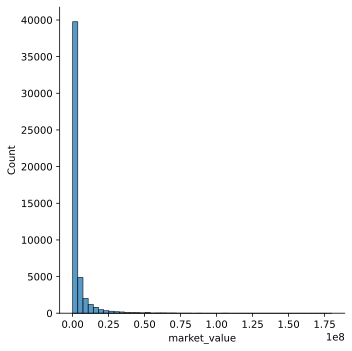

In [24]:
sns.displot(data = data['all'], x = 'market_value', bins = 50)

plt.show()

In [25]:
df_highest_market_value_players = data['all'].nlargest(n = 1, columns = 'market_value')

df_highest_market_value_players

,name,height,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,age,...,club_name_West Bromwich Albion,club_name_West Ham United,club_name_Wigan Athletic,club_name_Willem Ii Tilburg,club_name_Wolverhampton Wanderers,club_name_Yeni Malatyaspor,club_name_Zenit St Petersburg,club_name_Zirka Kropyvnytskyi,club_name_Zorya Lugansk,club_name_Zska Moskau
player_id,,,,,,,,,,,,,,,,,,,,,
342229,Kylian Mbappe,178,2019,180000000.0,24,12,2051,2,0,20.0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df_highest_market_value = data['all'].loc[data['all']['name'].isin(df_highest_market_value_players['name'])]

df_highest_market_value

,name,height,season,market_value,goals,assists,minutes_played,yellow_cards,red_cards,age,...,club_name_West Bromwich Albion,club_name_West Ham United,club_name_Wigan Athletic,club_name_Willem Ii Tilburg,club_name_Wolverhampton Wanderers,club_name_Yeni Malatyaspor,club_name_Zenit St Petersburg,club_name_Zirka Kropyvnytskyi,club_name_Zorya Lugansk,club_name_Zska Moskau
player_id,,,,,,,,,,,,,,,,,,,,,
342229,Kylian Mbappe,178,2015,45000.0,1,2,323,1,0,16.0,...,0,0,0,0,0,0,0,0,0,0
342229,Kylian Mbappe,178,2016,1518750.0,21,8,2108,2,0,17.0,...,0,0,0,0,0,0,0,0,0,0
342229,Kylian Mbappe,178,2017,40500000.0,17,10,2829,3,0,18.0,...,0,0,0,0,0,0,0,0,0,0
342229,Kylian Mbappe,178,2018,138600000.0,37,14,3030,7,1,19.0,...,0,0,0,0,0,0,0,0,0,0
342229,Kylian Mbappe,178,2019,180000000.0,24,12,2051,2,0,20.0,...,0,0,0,0,0,0,0,0,0,0
342229,Kylian Mbappe,178,2020,162000000.0,35,11,3583,6,0,21.0,...,0,0,0,0,0,0,0,0,0,0
342229,Kylian Mbappe,178,2021,144000000.0,31,25,3616,11,0,22.0,...,0,0,0,0,0,0,0,0,0,0


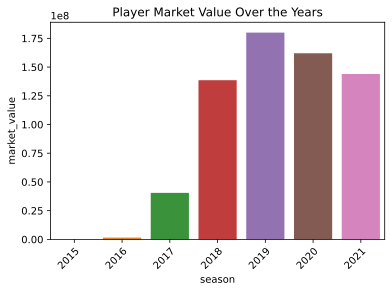

In [27]:
sns.barplot(data = df_highest_market_value, x = 'season', y = 'market_value')
plt.title('Player Market Value Over the Years')
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')

plt.show()

# Footnotes

<sup><a name="cariboo" href="#note-cariboo">7</a></sup> *Football Data from Transfermarkt.* (2022, April 22). [Dataset]. https://www.kaggle.com/datasets/davidcariboo/player-scores